In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tools.sm_exceptions import ValueWarning

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from bayes_opt import BayesianOptimization

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=ValueWarning, module='statsmodels')

# Functions
# Add the directory containing the module to sys.path
sys.path.append(os.path.abspath('functions'))
from preprocessing import read_csv_files, check_missing_values, forward_fill, backward_fill, linear_interpolation, calculate_volatility, adf_test, map_date_range, create_volatility_df, stationary_transformation
from spillover import calculate_avg_spillover_table, calculate_net_pairwise_spillover_table, calculate_rolling_spillover_table

/var/folders/16/cclqjy7n72d14ngr0ys9zwjr0000gn/T/ipykernel_7153/1183448142.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-08-14 16:56:56.404570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preprocessing

In [2]:
# Retrieve a list of DataFrames
dataframes = read_csv_files("data")

In [3]:
# Convert each column in every DataFrame to lowercase
for key in dataframes:
    dataframes[key].columns = map(str.lower, dataframes[key].columns)

Converting the `date` column to datetime object, this process has to be handled individually since each DataFrame has a different date format. We cannot let Pandas infers the date format for each DataFrame since it can be prone to infer the wrong format. Below are the format of each DataFrame:
- United Kingdom: DD/MM/YYYY
- Mexico: YYYY-MM-DD
- Japan: YYYY-MM-DD
- Korea: YYYY-MM-DD
- Thailand: YYYY-MM-DD
- Switzerland: YYYY-MM-DD
- United States: YYYY-MM-DD

In [4]:
date_format_mapping = {
  'uk': '%d/%m/%Y',
  'mexico': '%Y-%m-%d',
  'japan': '%Y-%m-%d',
  'korea': '%Y-%m-%d',
  'thailand': '%Y-%m-%d',
  'switzerland': '%Y-%m-%d',
  'us': '%Y-%m-%d',
}

# Convert the date columns to datetime objects
for key in dataframes:
    try:
      dataframes[key]['date'] = pd.to_datetime(
        dataframes[key]['date'], 
        format=date_format_mapping[key]
      )
    except Exception as e:
      print(f"Error occurred for country: {key}")
      print(f"Error message: {str(e)}")

In [5]:
# Sort the dataframes by date in ascending order
for key in dataframes:
    dataframes[key] = dataframes[key].sort_values(by='date')

In [6]:
# Reset the index of the dataframes
for key in dataframes:
    dataframes[key] = dataframes[key].reset_index(drop=True)

In [7]:
# Extract only open, high, low, close columns
for key in dataframes:
    dataframes[key] = dataframes[key][['date', 'open', 'high', 'low', 'close']]

In [8]:
for df in dataframes.values():
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5597 entries, 0 to 5596
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5597 non-null   datetime64[ns]
 1   open    5597 non-null   object        
 2   high    5597 non-null   object        
 3   low     5597 non-null   object        
 4   close   5597 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 218.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656 entries, 0 to 5655
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5656 non-null   datetime64[ns]
 1   open    5607 non-null   float64       
 2   high    5607 non-null   float64       
 3   low     5607 non-null   float64       
 4   close   5607 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 221.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Ra

Since the columns open, high, low, close have different dtypes (`float64` and `object`) for different DataFrame, they should be converted to `float64`.

In [9]:
# Convert open, high, low, close columns to float
for key in dataframes:
  for col in ['open', 'high', 'low', 'close']:
    if dataframes[key][col].dtype == 'object':
      dataframes[key][col] = dataframes[key][col].str.replace(',', '').astype(float)


In [10]:
# Check whether the columns have been converted to float
for df in dataframes.values():
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5597 entries, 0 to 5596
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5597 non-null   datetime64[ns]
 1   open    5597 non-null   float64       
 2   high    5597 non-null   float64       
 3   low     5597 non-null   float64       
 4   close   5597 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 218.8 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656 entries, 0 to 5655
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5656 non-null   datetime64[ns]
 1   open    5607 non-null   float64       
 2   high    5607 non-null   float64       
 3   low     5607 non-null   float64       
 4   close   5607 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 221.1 KB
None
<class 'pandas.core.frame.DataFrame'>
Ra

##### Data imputation

In [11]:
check_missing_values(dataframes)

Missing values for uk:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for mexico:
date      0
open     49
high     49
low      49
close    49
dtype: int64


Missing values for japan:
date      0
open     93
high     93
low      93
close    93
dtype: int64


Missing values for korea:
date      0
open     66
high     66
low      66
close    66
dtype: int64


Missing values for thailand:
date      0
open     73
high     73
low      73
close    73
dtype: int64


Missing values for switzerland:
date      0
open     52
high     52
low      52
close    52
dtype: int64


Missing values for us:
date     0
open     0
high     0
low      0
close    0
dtype: int64




In [12]:
# Impute missing values in the dataframes using linear interpolation method
dataframes = linear_interpolation(dataframes)

In [13]:
# Check whether the missing values have been imputed
check_missing_values(dataframes)

Missing values for uk:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for mexico:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for japan:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for korea:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for thailand:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for switzerland:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for us:
date     0
open     0
high     0
low      0
close    0
dtype: int64




##### Timeframe normalisation

In [14]:
# Map the dataframes to a new date range that includes all the business days from 2002-01-02 to 2024-04-30
dataframes = map_date_range(dataframes, '2002-01-02', '2024-04-30')

In [15]:
# Check for missing values after mapping the dataframes to a new date range
check_missing_values(dataframes)

Missing values for uk:
date       0
open     228
high     228
low      228
close    228
dtype: int64


Missing values for mexico:
date       0
open     169
high     169
low      169
close    169
dtype: int64


Missing values for japan:
date       0
open     266
high     266
low      266
close    266
dtype: int64


Missing values for korea:
date       0
open     247
high     247
low      247
close    247
dtype: int64


Missing values for thailand:
date       0
open     310
high     310
low      310
close    310
dtype: int64


Missing values for switzerland:
date       0
open     163
high     163
low      163
close    163
dtype: int64


Missing values for us:
date       0
open     205
high     205
low      205
close    205
dtype: int64




In [16]:
# Perform forward filling on the dataframes
dataframes = forward_fill(dataframes)

In [17]:
# Check for missing values after performing forward filling
check_missing_values(dataframes)

Missing values for uk:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for mexico:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for japan:
date     0
open     2
high     2
low      2
close    2
dtype: int64


Missing values for korea:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for thailand:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for switzerland:
date     0
open     0
high     0
low      0
close    0
dtype: int64


Missing values for us:
date     0
open     0
high     0
low      0
close    0
dtype: int64




In [18]:
# Perform backward filling on the dataframes to handle any remaining missing values
dataframes = backward_fill(dataframes)

##### Volatility calculation

In [19]:
# Calculate the volatility for each country
dataframes = calculate_volatility(dataframes)

In [20]:
# Create volatility Dataframe
volatility_df = create_volatility_df(dataframes)

# Save the volatility DataFrame to a CSV file
volatility_df.to_csv('output/volatility.csv', index=False)

# Reset the date column to index
volatility_df = volatility_df.set_index('date')

In [21]:
# Describe the volatility DataFrame
print(volatility_df.describe())

                uk       mexico        japan        korea     thailand  \
count  5825.000000  5825.000000  5825.000000  5825.000000  5825.000000   
mean     15.565810    16.232517    15.048724    15.902134    14.199264   
std      10.705950     9.454911     9.627075    10.553704     9.174539   
min       0.000000     2.830016     0.000000     2.995946     0.000000   
25%       9.109668    10.438909     9.132586     9.474912     8.971136   
50%      12.704654    14.094775    12.856533    13.153689    12.081416   
75%      18.602845    19.317213    18.161788    19.097687    16.797115   
max     122.219051   131.691247   158.737967   202.360775   227.451095   

       switzerland           us  
count  5825.000000  5825.000000  
mean     14.343207    14.547697  
std      10.137967    11.003696  
min       0.000000     1.834197  
25%       8.510257     7.897507  
50%      11.639171    11.692481  
75%      16.707431    17.590150  
max     187.223743   153.118266  


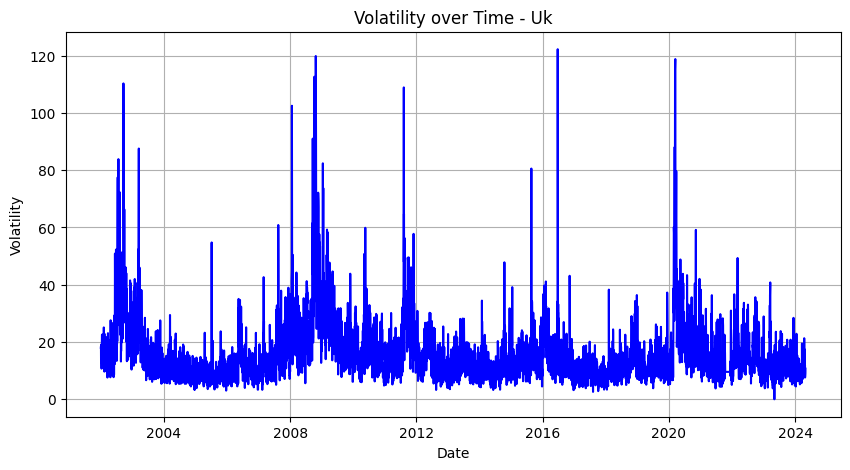

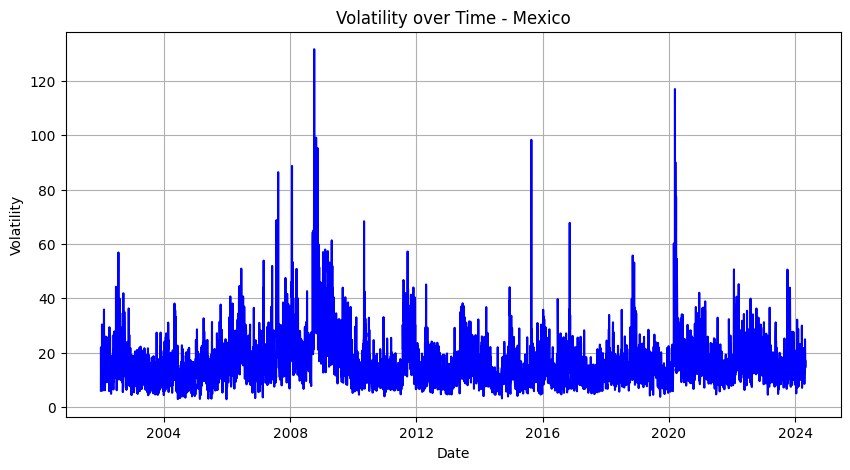

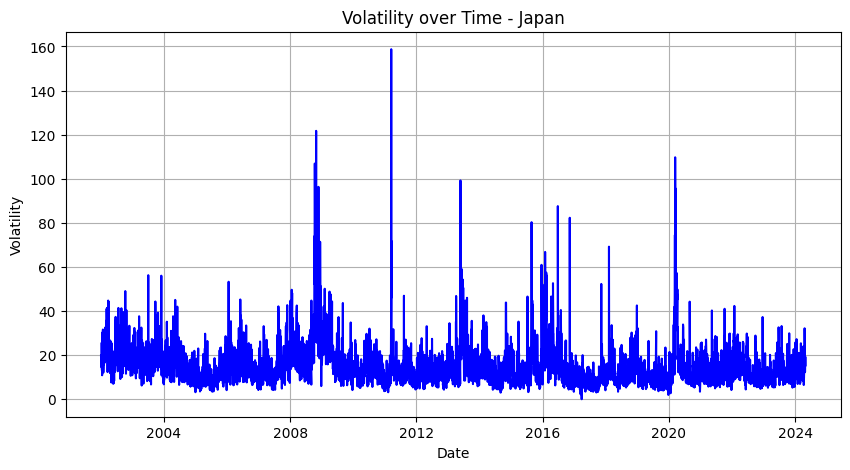

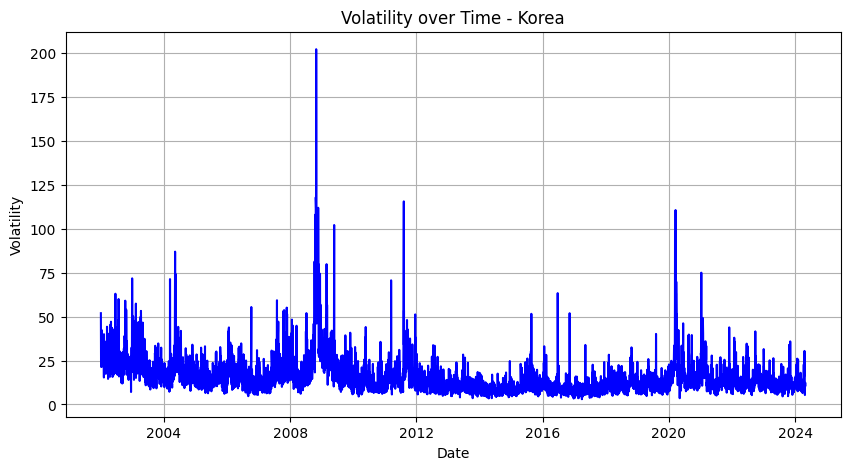

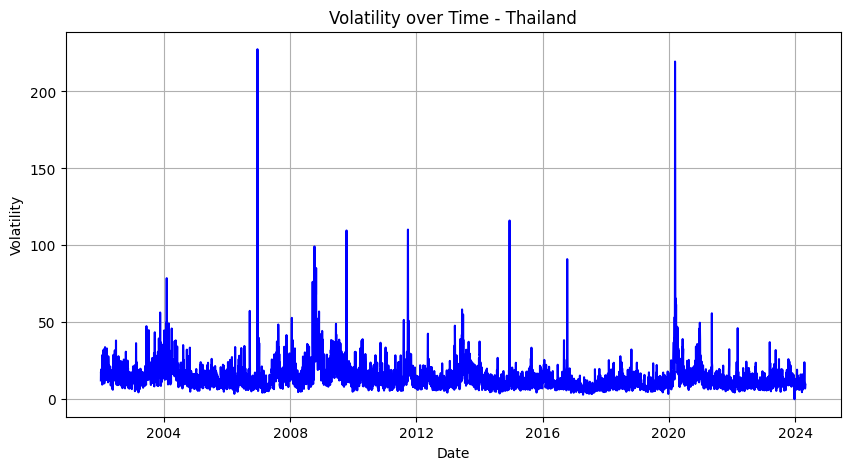

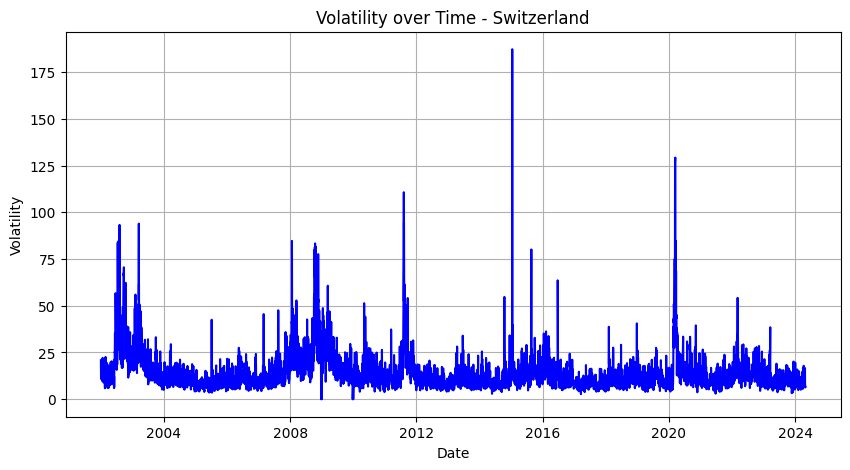

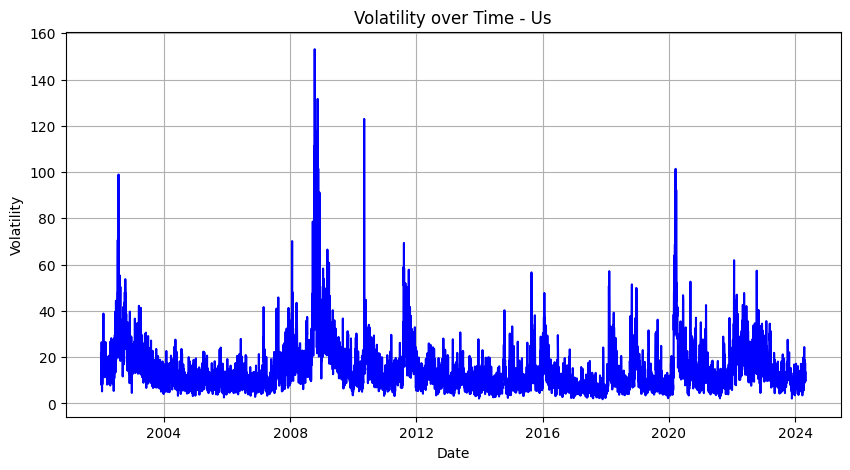

In [22]:
# Visualize the volatility of each country
for column in volatility_df.columns:
  plt.figure(figsize=(10, 5))
  plt.plot(volatility_df.index, volatility_df[column], label=column, color='blue')
  plt.title(f'Volatility over Time - {column.capitalize()}')
  plt.xlabel('Date')
  plt.ylabel('Volatility')
  plt.grid(True)
  plt.savefig(f'output/plots/volatility_{column.upper()}.png')  # Save the plot
  plt.show()


##### Augmented Dickey-Fuller (ADF) test

In [23]:
for country in volatility_df.columns:
  adf_test(volatility_df, country)

Results of Augmented Dickey-Fuller Test for uk:
ADF Statistic: -6.240839580494232
p-value: 4.701620665518484e-08
Critical Values:
	1%: -3.431478938567795
	5%: -2.8620388838347126
	10%: -2.567035553878898
Reject the null hypothesis. The time series uk is stationary.


Results of Augmented Dickey-Fuller Test for mexico:
ADF Statistic: -6.7110582149695945
p-value: 3.679790469568243e-09
Critical Values:
	1%: -3.4314799139042953
	5%: -2.862039314759095
	10%: -2.5670357832723325
Reject the null hypothesis. The time series mexico is stationary.


Results of Augmented Dickey-Fuller Test for japan:
ADF Statistic: -8.297506928092286
p-value: 4.1021193335394816e-13
Critical Values:
	1%: -3.4314777703843267
	5%: -2.8620383677062575
	10%: -2.567035279128919
Reject the null hypothesis. The time series japan is stationary.


Results of Augmented Dickey-Fuller Test for korea:
ADF Statistic: -7.706244778847388
p-value: 1.2993121296025538e-11
Critical Values:
	1%: -3.4314775759220844
	5%: -2.86203828178

All of the variables are stationary. Therefore, no transformation is needed.

## VAR Modelling

##### Average Spillover Table

In [24]:
print("Calculating spillover ...")
# Calculate the average spillover for each window
spillovers_table, lag_order, forecast_horizon = calculate_avg_spillover_table(
    volatility_df
)
print("Finished calculating spillover!")
print(f"Lag order: {lag_order}")
print(f"Forecast horizon: {forecast_horizon}")
print("Saving spillover table ...")
# Save the spillover table to a CSV file
spillovers_table.to_csv(
    "output/var/average_spillover_table.csv", index=True
)
print("Finished saving spillover table!")
print()
print(spillovers_table)

Calculating spillover ...
Finished calculating spillover!
Lag order: 14
Forecast horizon: 10
Saving spillover table ...
Finished saving spillover table!

                                      uk      mexico      japan      korea  \
uk                             47.909719    7.433728   2.479124   2.613409   
mexico                          8.874072   62.985094   2.356071   1.872438   
japan                           6.825966    5.482039  60.715357   6.886316   
korea                           5.173698    4.114027   5.992750  66.750890   
thailand                        4.813754    3.788957   2.497534   3.246038   
switzerland                    23.492787    4.992672   2.888600   2.780536   
us                             14.060381   12.081502   2.847298   1.786757   
Directional TO others          63.240658   37.892926  19.061378  19.185494   
Directional TO including own  111.150376  100.878020  79.776735  85.936384   
Total spillover index          40.014528   40.014528  40.014528  4

##### Net Pair-wise Spillover Table

In [25]:
print(f"Calculating net pair-wise spillover...")
# Read the spillover table for the current window
spillover_table = pd.read_csv(f"output/var/average_spillover_table.csv", index_col=0)
# Calculate the net pair-wise spillover for the current window
normalized_spillover_table = spillover_table.drop(index=['Directional TO others', 'Directional TO including own', 'Total spillover index']).drop(columns=['Directional FROM others'])
net_pairwise_spillover_table = calculate_net_pairwise_spillover_table(normalized_spillover_table)
print(f"Finished calculating net pair-wise spillover!")
print(f"Saving net pair-wise spillover table...")
# Save the net pair-wise spillover table to a CSV file
net_pairwise_spillover_table.to_csv(f"output/var/net_pairwise_spillover_table.csv", index=True)
print(f"Finished saving net pair-wise spillover table!")
print()
print(net_pairwise_spillover_table)

Calculating net pair-wise spillover...
Finished calculating net pair-wise spillover!
Saving net pair-wise spillover table...
Finished saving net pair-wise spillover table!

                    uk     mexico       japan      korea   thailand  \
uk            0.000000  20.576336   62.097732  36.575563  34.913474   
mexico      -20.576336   0.000000   44.656683  32.022706  32.611281   
japan       -62.097732 -44.656683    0.000000 -12.765226  -8.139615   
korea       -36.575563 -32.022706   12.765226   0.000000  -4.617793   
thailand    -34.913474 -32.611281    8.139615   4.617793   0.000000   
switzerland -26.908348  13.211515   54.920210  48.740607  29.355857   
us           21.780365  62.959680  106.324325  91.717352  35.274929   

             switzerland          us  
uk             26.908348  -21.780365  
mexico        -13.211515  -62.959680  
japan         -54.920210 -106.324325  
korea         -48.740607  -91.717352  
thailand      -29.355857  -35.274929  
switzerland     0.000000

##### Rolling Window Spillover Table

In [26]:
window_size = 200
# Calculate the rolling spillover for every N days
rolling_spillover_table = calculate_rolling_spillover_table(volatility_df, window_size)

Calculating rolling window spillover...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 5626/5626 [04:35<00:00, 20.41it/s]


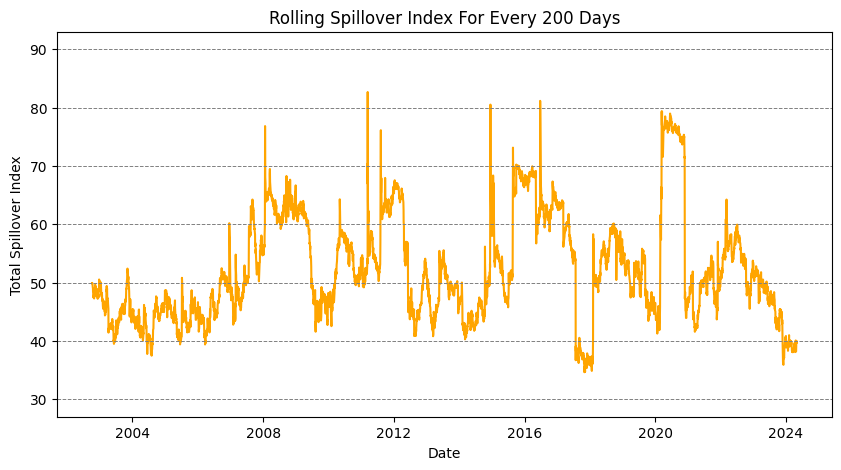

In [27]:
# Graph the rolling spillover
plt.figure(figsize=(10, 5))
plt.plot(rolling_spillover_table.index, rolling_spillover_table['Total Spillover Index'], label='Total spillover index', color='orange')
ax = plt.gca()
y_values = ax.get_yticks()
for y in y_values:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
plt.title(f'Rolling Spillover Index For Every {window_size} Days')
plt.xlabel('Date')
plt.ylabel('Total Spillover Index')

# Save the plot
plt.savefig(f'output/plots/{window_size}_days_rolling_spillover.png')

## Out of sample forecast

### LSTM model prediction

##### Data preparation

In [90]:
# Split the data into sub periods
gfc_volatility_df = volatility_df.loc[:'2008-02-29']
covid_volatility_df = volatility_df.loc['2009-07-31':'2021-03-09']

# Calulate the rolling spillover for each sub period
gfc_rolling_spillover_table = calculate_rolling_spillover_table(gfc_volatility_df, window_size)
covid_rolling_spillover_table = calculate_rolling_spillover_table(covid_volatility_df, window_size)

Calculating rolling window spillover...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2829/2829 [00:42<00:00, 66.84it/s]


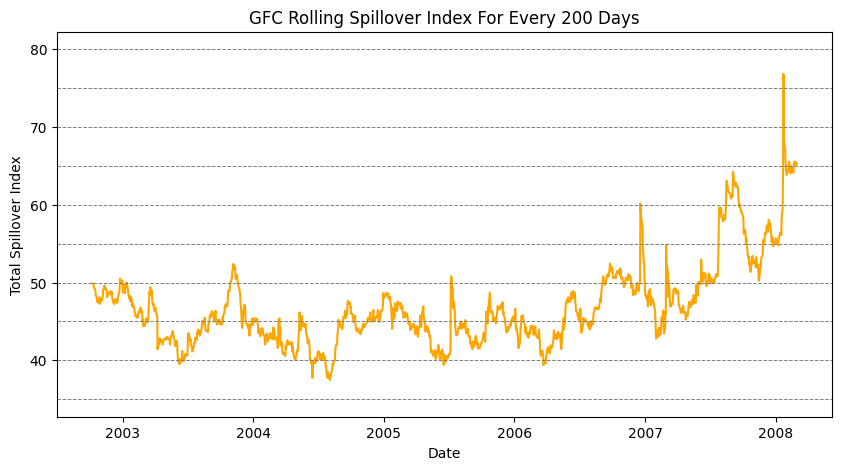

In [91]:
# Graph the rolling spillover
plt.figure(figsize=(10, 5))
plt.plot(gfc_rolling_spillover_table.index, gfc_rolling_spillover_table['Total Spillover Index'], label='Total spillover index', color='orange')
ax = plt.gca()
y_values = ax.get_yticks()
for y in y_values:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
plt.title(f'GFC Rolling Spillover Index For Every {window_size} Days')
plt.xlabel('Date')
plt.ylabel('Total Spillover Index')

# Save the plot
plt.savefig(f'output/plots/gfc_{window_size}_days_rolling_spillover.png')

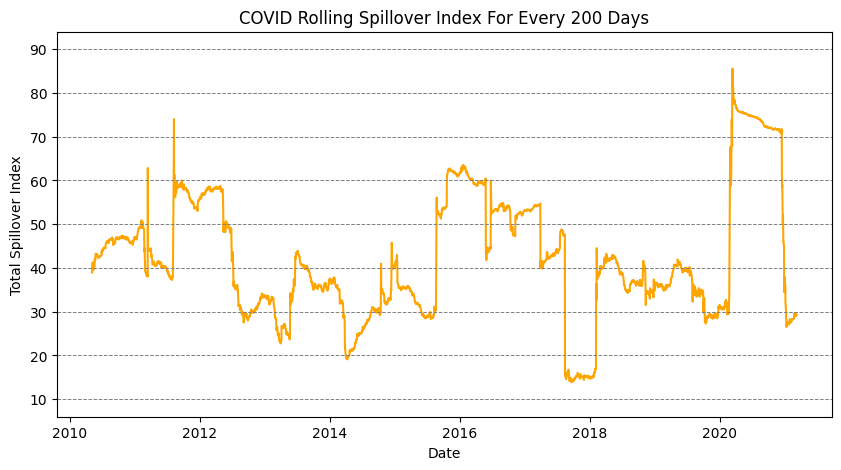

In [92]:
# Graph the rolling spillover
plt.figure(figsize=(10, 5))
plt.plot(covid_rolling_spillover_table.index, covid_rolling_spillover_table['Total Spillover Index'], label='Total spillover index', color='orange')
ax = plt.gca()
y_values = ax.get_yticks()
for y in y_values:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.7)
plt.title(f'COVID Rolling Spillover Index For Every {window_size} Days')
plt.xlabel('Date')
plt.ylabel('Total Spillover Index')

# Save the plot
plt.savefig(f'output/plots/covid_{window_size}_days_rolling_spillover.png')

In [104]:
# Define the number of lags
lags = 30
# Define the forecast horizon
forecast_horizon = 20
# Define the number of features
num_feat = 1

# Function to create lagged features
def create_lags(df: pd.Series, lags: int) -> pd.DataFrame:
    lagged_data = pd.concat([df.shift(i) for i in range(1, lags + 1)], axis=1)
    lagged_data.columns = [f'lag_{i}' for i in range(1, lags + 1)]
    return lagged_data

# Function ro prepare the target variable
def prepare_target(df: pd.Series, forecast_horizon: int) -> pd.Series:
    return df.shift(-forecast_horizon)

# Function to create the lagged dataset
def create_lagged_dataset(df: pd.Series, lags: int, forecast_horizon: int) -> pd.DataFrame:
    lagged_df = create_lags(df, lags)
    target = prepare_target(df, forecast_horizon)
    combined = pd.concat([lagged_df, target], axis=1)
    combined.dropna(inplace=True)
    return combined

# Function to split the data into training and testing sets
def split_data(data: np.ndarray, split_ratio: float = 0.8):
    split_index = int(split_ratio * len(data))
    train_data = data[:split_index]
    test_data = data[split_index:]
    return train_data, test_data

rolling_spillover_tables = {'gfc': gfc_rolling_spillover_table, 'covid':covid_rolling_spillover_table}

processed = {}




for key, df in rolling_spillover_tables.items():
    # Process the rolling spillover table
    scaler = StandardScaler()
    scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

    # Create the lagged dataset
    lagged = create_lagged_dataset(scaled['Total Spillover Index'], lags, forecast_horizon)

    # Split the data into features and target
    X = lagged.iloc[:, :-1].values
    y = lagged.iloc[:, -1].values

    # Reshape the data
    X = X.reshape(X.shape[0], lags, num_feat)
    y = y.reshape(-1, 1)

    X_train, X_test = split_data(X)
    y_train, y_test = split_data(y)

    processed[key] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler
    }

##### Construct and train the models

In [107]:
def build_and_train_model(
    X_train, 
    y_train,
    units,
    dropout_rate,
    optimizer,
    learning_rate,
    epochs,
    batch_size,
    activation_func
):
    units = int(units)
    batch_size = int(batch_size)
    epochs = int(epochs)
    optimizer = int(round(optimizer))
    activation_func = int(round(activation_func))

    activation_funcs = ['relu', 'tanh', 'sigmoid']

    if optimizer == 0:
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 1:
        optimizer = RMSprop(learning_rate=learning_rate)

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=units, activation=activation_funcs[activation_func], return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=units, activation=activation_funcs[activation_func], return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, activation=activation_funcs[activation_func], return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, activation=activation_funcs[activation_func]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_feat))
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping])
    
    return model

# Function to run Bayesian Optimization for a single dataset
def optimize_lstm(X_train, y_train):
    # Define the hyperparameters
    pbounds = {
        'units': (64, 128),
        'dropout_rate': (0.2, 0.4),
        'optimizer': [0, 1],
        'learning_rate': (0.0001, 0.01),
        'epochs': (500, 600),
        'batch_size': (16, 64),
        'activation_func': (0, 2),
    }

    def optimization_function(units, dropout_rate, optimizer, learning_rate, epochs, batch_size, activation_func):
        model = build_and_train_model(X_train, y_train, units, dropout_rate, optimizer, learning_rate, epochs, batch_size, activation_func)
        
        train_mse = model.history.history['loss'][-1]

        return -train_mse  # Return negative MSE for maximization
    
    optimizer = BayesianOptimization(
        f=optimization_function,
        pbounds=pbounds,
        random_state=42,
        verbose=2
    )
    
    optimizer.maximize(init_points=10, n_iter=10)
    
    return optimizer.max['params'], optimizer.max['target']

# Run Bayesian Optimization for each dataset
best_models = {}

for key, data in processed.items():
    X_train, y_train = data['X_train'], data['y_train']

    # Optimize the LSTM model
    print(f"Optimizing LSTM model for {key} dataset ...")
    best_params, best_mse = optimize_lstm(X_train, y_train)
    print(f"Best MSE: {best_mse}")
    print(f"Best parameters: {best_params}")

    # Build and train the best LSTM model
    print(f"Building and training the best LSTM model for {key} dataset ...")
    best_model = build_and_train_model(X_train, y_train, **best_params)
    print(f"Finished building and training the best LSTM model for {key} dataset!")

    # Save the best model
    best_models[key] = best_model
    best_model.save(f"output/models/{key}_lstm_model.h5")

Optimizing LSTM model for gfc dataset ...
|   iter    |  target   | activa... | batch_... | dropou... |  epochs   | learni... | optimizer |   units   |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.03365  | 0.7491    | 61.63     | 0.3464    | 559.9     | 0.001645  | 0.156     | 67.72     |
| 2         | -0.05926  | 1.732     | 44.85     | 0.3416    | 502.1     | 0.009702  | 0.8324    | 77.59     |
| 3         | -0.08794  | 0.3636    | 24.8      | 0.2608    | 552.5     | 0.004376  | 0.2912    | 103.2     |
| 4         | -0.2667   | 0.279     | 30.02     | 0.2733    | 545.6     | 0.007873  | 0.1997    | 96.91     |
| 5         | -0.01663  | 1.185     | 18.23     | 0.3215    | 517.1     | 0.000744  | 0.9489    | 125.8     |
| 6         | -0.04551  | 1.617     | 30.62     | 0.2195    | 568.4     | 0.004458  | 0.122     | 95.69     |
| 7         | -0.03388  | 0.06878   | 59.65     | 0.2518    | 566.3     | 0.00

##### Models evaluation

9/9 [==============================] - 4s 51ms/step
MSE for gfc period: 93.4628309541778


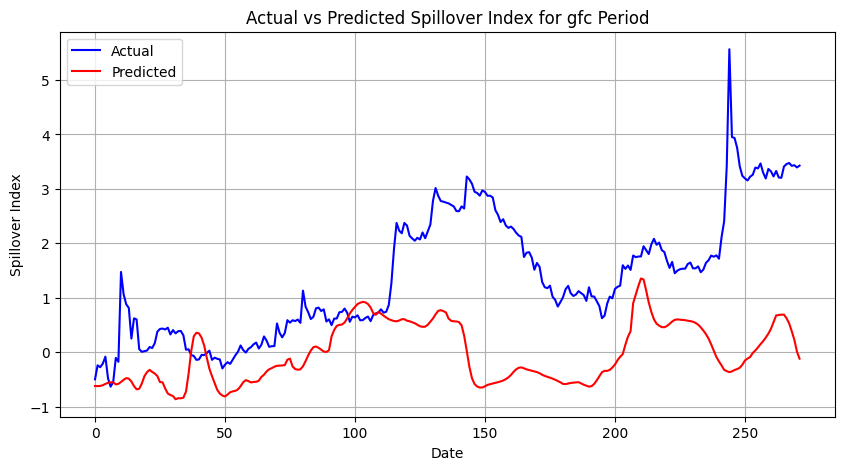

18/18 [==============================] - 6s 65ms/step
MSE for covid period: 202.81982585182


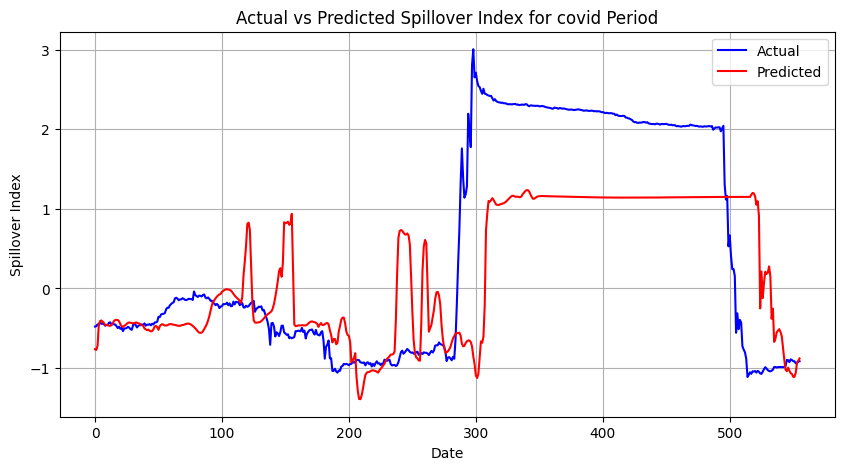

In [108]:
for period, best_model in best_models.items():
    # Get the processed data
    data = processed[period]
    X_test, y_test, scaler = data['X_test'], data['y_test'], data['scaler']

    # Make predictions using the best model
    y_pred = best_model.predict(X_test)

    # Inverse transform the predictions
    y_pred_inversed = scaler.inverse_transform(y_pred).reshape(-1)
    y_test_inversed = scaler.inverse_transform(y_test).reshape(-1)

    # Calculate the MSE
    mse = mean_squared_error(y_pred_inversed, y_test_inversed)
    print(f"MSE for {period} period: {mse}")

    # Plot the predictions
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red')
    plt.title(f'Actual vs Predicted Spillover Index for {period} Period')
    plt.xlabel('Date')
    plt.ylabel('Spillover Index')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'output/plots/{period}_spillover_predictions.png')
    plt.show()